In [1]:
%matplotlib notebook

In [2]:
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import DistanceMetric

import random
import itertools
import datetime
import math
import os

In [41]:
# Distances

def haversine(lat1, lon1, lat2, lon2, scale=3961):
    """
    The haversine distance is used to find the distance between two points on a sphere.
    
    scale is an approx. radius of the earth in miles
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = scale * c
    return km

def distance(a, b):
    diff = a - b
    exp = np.power(diff, 2)
    agg = np.sum(exp)
    root = np.sqrt(agg)
    return root

def alldistance(z):
    zdiff = z.reshape(-1, 1, 2) - z.reshape(1, -1, 2)
    zexp = np.power(zdiff, 2)
    zagg = np.sum(zexp, 2)
    zroot = np.sqrt(zagg)
    return zroot

# Shortest Path (by heuristic)

def nextclosest_helper(pointindex, startindex, endindex, z, zdist, mindist=0.2):
    point = z[pointindex]
    start = z[startindex]
    end = z[endindex]

    dist = zdist[pointindex]
    psdist = zdist[startindex, pointindex]
    pedist = zdist[pointindex, endindex]
    sdist = zdist[:, startindex]
    edist = zdist[:, endindex]
    
    index = np.arange(z.shape[0])
    mask = np.logical_and(dist >= 0, np.logical_and(sdist >= psdist, edist <= pedist))
    mask = np.logical_and(mask, dist >= mindist)
    
    dmask = dist[mask]
    imask = index[mask]
    
    argmin = np.argmin(dmask)

    return imask[argmin]

def nextclosest(pointindex, startindex, endindex, z, zdist, mindist=0.3, ntries=3):
    __mindist = mindist
    closest = None
    for i in range(ntries):
        try:
            closest = nextclosest_helper(pointindex, startindex, endindex, z, zdist, mindist=__mindist)
        except:
            __mindist = mindist - (mindist / ntries) * (i+1)
    return closest

def heuristic_path(startindex, endindex, z, zdist, mindist=0.3, noise_scale=math.inf, eps=1e-8):
    start = z[startindex]
    end = z[endindex]

    closest = start
    nextindex = startindex
    pathindex = [startindex]

    count = 0

    for _ in tqdm(itertools.repeat(None)):
        noise = np.random.normal(size=1, scale=mindist/noise_scale)
        __mindist = mindist + noise

        prevclosest = closest
        
        nextindex = nextclosest(nextindex, startindex, endindex, z, zdist, mindist=__mindist)
        
        if nextindex is None:
            nextindex = endindex
        
        closest = z[nextindex]
        prev2now = distance(prevclosest, closest)
        prev2end = distance(prevclosest, end)

        if prev2now + eps >= prev2end:
            nextindex = endindex
            closest = end
        
        pathindex.append(nextindex)
        
        if nextindex == endindex:
            break

        count += 1

        if count > z.shape[0]:
            raise RuntimeError('Loop did not terminate.')

    path = z[pathindex]
    
    return path, pathindex

def sample_points():
    # State

    np.random.seed(11)

    # Config

    xdim = 10
    ydim = 1
    n = 2000

    start = np.array([-3, 0])
    end = np.array([3, 0])
    loc = (start[0] + end[0]) / 2
    scale = end[0]

    # Generate Points

    xs = np.random.normal(size=n, loc=loc, scale=scale)
    ys = np.random.normal(size=n) * ydim

    ys = np.array([y for x, y in zip(xs, ys) if x > start[0] and x < end[0]])
    xs = np.array([x for x in xs if x > start[0] and x < end[0]])

    z = np.concatenate([xs.reshape(-1, 1), ys.reshape(-1, 1)], axis=1)
    z = np.concatenate([start.reshape(1, 2), z, end.reshape(1, 2)], axis=0)
    
    return z

def generate_track(z, start_index=None, end_index=None, mindist=0.6, noise_scale=10):
    """
    mindist = 0.6
    noise_scale = 10  # use math.inf to ignore
    """
    
    if start_index is None:
        print('setting start_index')
        start_index = 0
    if end_index is None:
        print('setting end_index')
        end_index = z.shape[0] - 1
    
    start = z[start_index]
    end = z[end_index]

    zdist = alldistance(z)

    path, pathindex = heuristic_path(start_index, end_index, z, zdist, mindist=mindist, noise_scale=noise_scale)

    print('Path Length = {}'.format(path.shape[0]))
    
    return path, pathindex

def visualize(z, path, names=None):
    """
    TODO: Print a scale showing distance.
    TODO: Print some of lat/lon lines.
    """
    # Visualize

    plt.figure()

    plt.scatter(z[:, 0], z[:, 1], color='y')
    plt.plot(path[:, 0], path[:, 1], color='g')
    plt.scatter(path[1:-1, 0], path[1:-1, 1], color='g')
    plt.scatter([path[0, 0], path[-1, 0]], [path[0, 1], path[-1, 1]], color='orange')
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')

    plt.axis('equal')
    
    if names is not None:
        print('labeling')
        for i, label in enumerate(names):
            point = path[i]
            plt.annotate(
                label,
                xy=point, xytext=(-20, 20),
                textcoords='offset points', ha='right', va='bottom',
#                 bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

    plt.show()

setting start_index
setting end_index



Path Length = 16


<IPython.core.display.Javascript object>


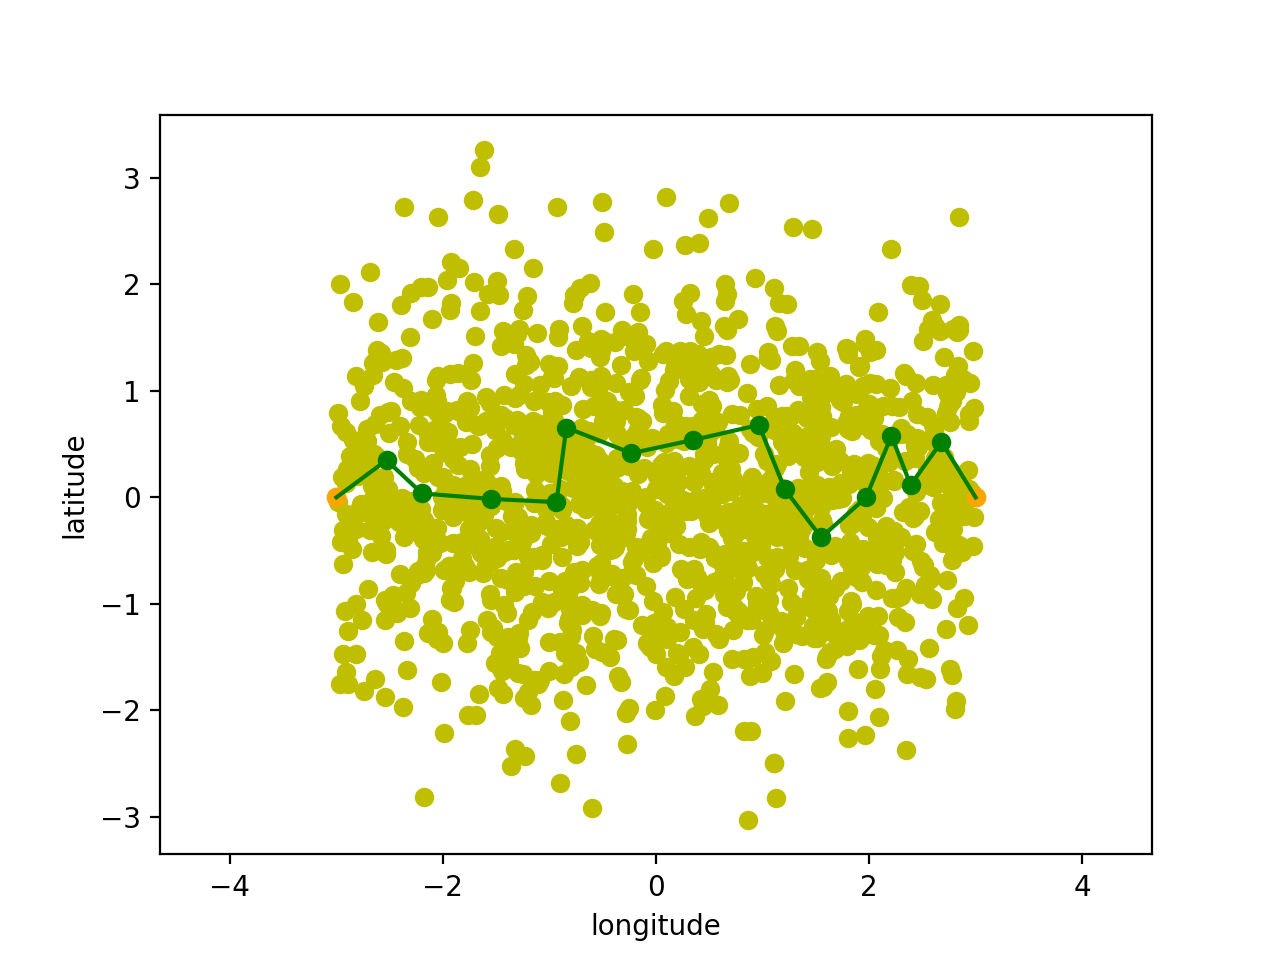

In [30]:
z = sample_points()
path, _ = generate_track(z=z)
visualize(z, path)
print()

In [31]:
def read_csv(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            parts = line.split('|')
            lon, lat, name = float(parts[2]), float(parts[3]), parts[4]
            points.append((lat, lon, name))
    return points

In [49]:
# https://www.openstreetmap.org/export#map=12/40.8504/-73.8817
# extracted POIs: https://github.com/MorbZ/OsmPoisPbf
# convert osm to pbf using osmosis (brew install osmosis)
# 
# osmosis --read-xml file="big-map.osm" --write-pbf file="big-map.osm.pbf"
# java -Xmx4g -jar osmpois.jar big-map.osm.pbf
#
filename = os.path.expanduser('../passenger/simulate/examples/map-nyc.csv')
points = read_csv(filename)

In [33]:
limit = 2000
index = random.sample(range(len(points)), limit)
downsampled = [points[i] for i in index]

lats, lons, names = zip(*downsampled)

def asnp(x):
    return np.array(x)

z = np.concatenate([asnp(lats).reshape(-1, 1), asnp(lons).reshape(-1, 1)], axis=1)

2000
1405 9


<IPython.core.display.Javascript object>


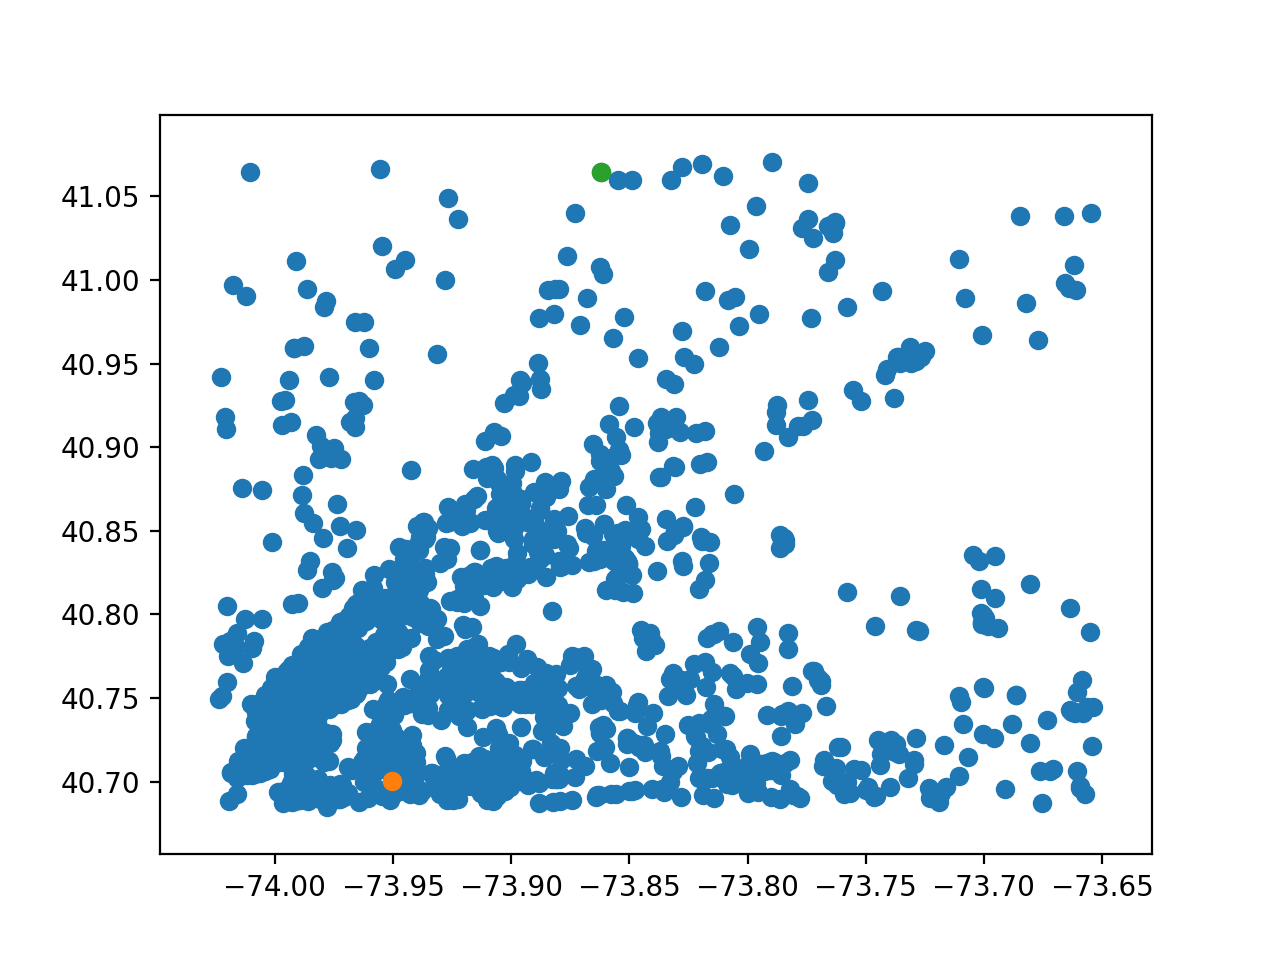

In [39]:
def find_closest(anchor, z):
    zplus = np.concatenate([anchor.reshape(1, 2), z], axis=0)
    zdist = alldistance(zplus)
    dist = zdist[0]
    index = np.arange(zplus.shape[0])
    mask = dist > 0
    argmin = np.argmin(dist[mask])
    return index[mask][argmin] - 1

print(len(lats))
startindex = find_closest(np.array([-73.95, 40.7]), z)
endindex = find_closest(np.array([-73.85, 41.1]), z)

print(startindex, endindex)

plt.figure()
plt.scatter(z[:, 0], z[:, 1])
plt.scatter(z[startindex, 0], z[startindex, 1])
plt.scatter(z[endindex, 0], z[endindex, 1])
plt.show()


Path Length = 11


<IPython.core.display.Javascript object>


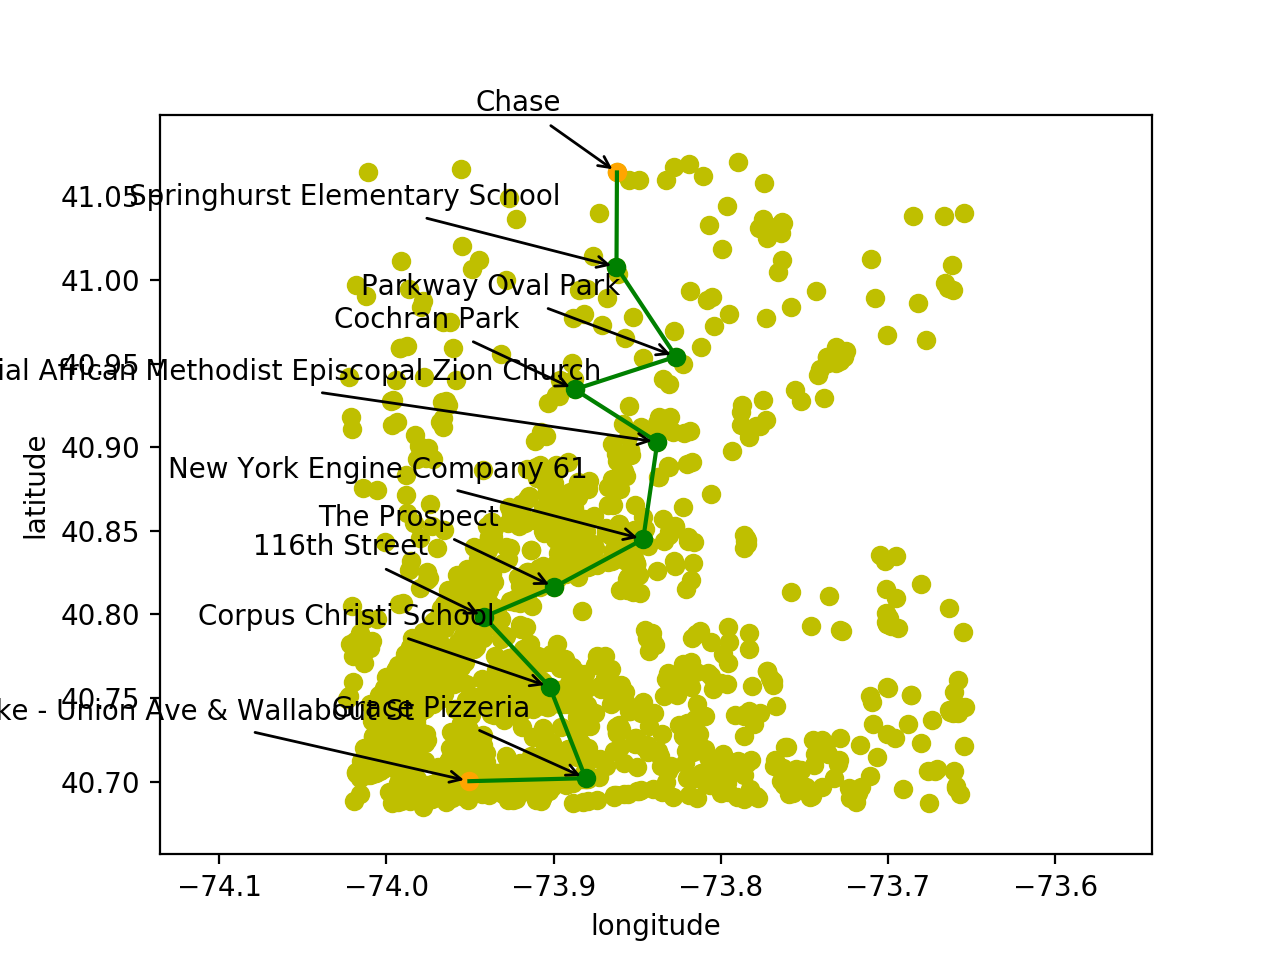

labeling


In [44]:
np.random.seed(11)  # for the noise

path, pathindex = generate_track(z=z, noise_scale=11, mindist=0.06, start_index=startindex, end_index=endindex)
pathnames = [names[i] for i in pathindex]

visualize(z, path, names=pathnames)

In [45]:
class ScheduleSimulator(object):
    average_speed = 60  # mph
    initial_date = datetime.datetime(year=2018, month=1, day=1, hour=7)
    one_hour = datetime.timedelta(0, 0, 0, 0, 0, 1)
    
    def __init__(self, path, ntrains, delay=datetime.timedelta(0, 0, 0, 0, 10)):
        self.path = path
        self.ntrains = ntrains
        self.delay = delay
        
    def format_time(self, dt):
        return dt.strftime('%Y-%m-%d %I:%M %p')
        
    def simulate(self):
        start = self.initial_date
        
        for i in range(self.ntrains):
            mytime = start + i * self.delay
            
            print('train: {}\tstation: {}\ttime: {}'.format(i, 0, self.format_time(mytime)))
            
            for ip in range(1, path.shape[0]):
                pprev = path[ip-1]
                pnow = path[ip]
                dist = haversine(pprev[0], pprev[1], pnow[0], pnow[1])
    
                mytime = mytime + dist / self.average_speed * self.one_hour
                
                print('train: {}\tstation: {}\ttime: {}'.format(i, ip, self.format_time(mytime)))
            

In [46]:
ScheduleSimulator(path, 2).simulate()

train: 0	station: 0	time: 2018-01-01 07:00 AM
train: 0	station: 1	time: 2018-01-01 07:04 AM
train: 0	station: 2	time: 2018-01-01 07:06 AM
train: 0	station: 3	time: 2018-01-01 07:09 AM
train: 0	station: 4	time: 2018-01-01 07:12 AM
train: 0	station: 5	time: 2018-01-01 07:16 AM
train: 0	station: 6	time: 2018-01-01 07:17 AM
train: 0	station: 7	time: 2018-01-01 07:20 AM
train: 0	station: 8	time: 2018-01-01 07:25 AM
train: 0	station: 9	time: 2018-01-01 07:27 AM
train: 0	station: 10	time: 2018-01-01 07:28 AM
train: 1	station: 0	time: 2018-01-01 07:10 AM
train: 1	station: 1	time: 2018-01-01 07:14 AM
train: 1	station: 2	time: 2018-01-01 07:16 AM
train: 1	station: 3	time: 2018-01-01 07:19 AM
train: 1	station: 4	time: 2018-01-01 07:22 AM
train: 1	station: 5	time: 2018-01-01 07:26 AM
train: 1	station: 6	time: 2018-01-01 07:27 AM
train: 1	station: 7	time: 2018-01-01 07:30 AM
train: 1	station: 8	time: 2018-01-01 07:35 AM
train: 1	station: 9	time: 2018-01-01 07:37 AM
train: 1	station: 10	time: 2018-0

In [47]:
dt = datetime.datetime(year=2018, month=2, day=3, hour=16, second=2)

print(dt)

print()

print(dt + datetime.timedelta(1), 'day')
print(dt + datetime.timedelta(0, 1), 'second')
print(dt + datetime.timedelta(0, 0, 1), 'microsecond')
print(dt + datetime.timedelta(0, 0, 0, 1), 'millisecond')
print(dt + datetime.timedelta(0, 0, 0, 0, 1), 'minute')
print(dt + datetime.timedelta(0, 0, 0, 0, 0, 1), 'hour')
print(dt + datetime.timedelta(0, 0, 0, 0, 0, 0, 1), 'week')

print()

fmtstr = '%Y'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%m'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%d'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%H'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%M'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%S'; print(dt.strftime(fmtstr), '\t', fmtstr)

print()

fmtstr = '%I'; print(dt.strftime(fmtstr), '\t', fmtstr)
fmtstr = '%p'; print(dt.strftime(fmtstr), '\t', fmtstr)

2018-02-03 16:00:02

2018-02-04 16:00:02 day
2018-02-03 16:00:03 second
2018-02-03 16:00:02.000001 microsecond
2018-02-03 16:00:02.001000 millisecond
2018-02-03 16:01:02 minute
2018-02-03 17:00:02 hour
2018-02-10 16:00:02 week

2018 	 %Y
02 	 %m
03 	 %d
16 	 %H
00 	 %M
02 	 %S

04 	 %I
PM 	 %p


In [35]:
path

array([[-73.9502206,  40.7001535],
       [-73.9335532,  40.7435086],
       [-73.9616667,  40.7708333],
       [-73.9552779,  40.8091666],
       [-73.9388889,  40.8347222],
       [-73.9105556,  40.8633333],
       [-73.8922222,  40.8977778],
       [-73.8587459,  40.9159324],
       [-73.8437453,  40.9542652],
       [-73.8696255,  41.0946092]])

In [36]:
haversine(40.7529, -73.97731, 40.738642, -73.987915)

1.1314172847442867

In [37]:
haversine(path[0, 1], path[0, 0], path[1, 1], path[1, 0])

3.1218749385817115